n=    0  CFL=0.063  max|div|=7.631e-01
n=  200  CFL=0.063  max|div|=2.692e+00
n=  400  CFL=0.063  max|div|=2.698e+00
n=  600  CFL=0.063  max|div|=2.700e+00
n=  800  CFL=0.063  max|div|=2.700e+00
n= 1000  CFL=0.063  max|div|=2.701e+00
n= 1200  CFL=0.063  max|div|=2.701e+00
n= 1400  CFL=0.063  max|div|=2.701e+00
n= 1600  CFL=0.063  max|div|=2.701e+00
n= 1800  CFL=0.063  max|div|=2.701e+00


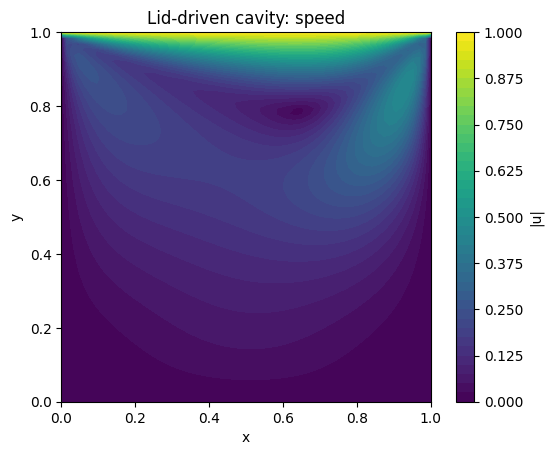

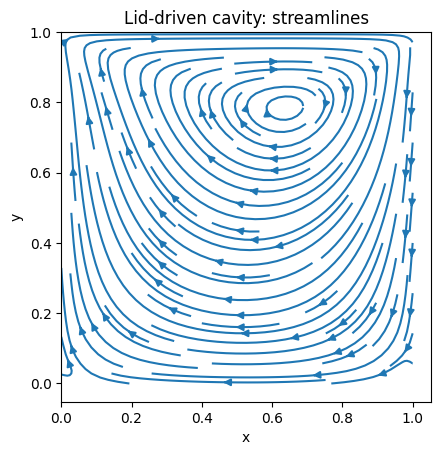

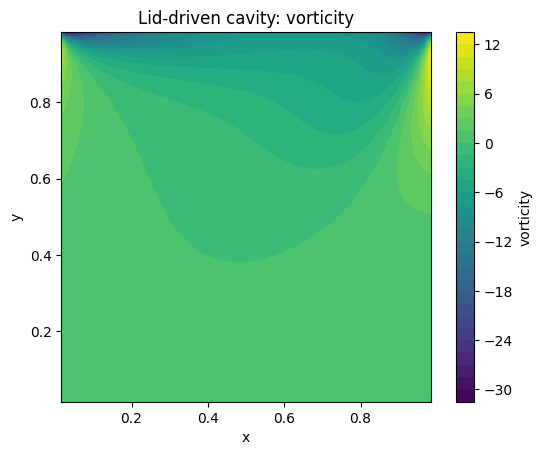

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Lid-driven cavity parameters
# -----------------------------
L = 1.0
Nx = 64
Ny = 64
dx = L/(Nx-1)
dy = L/(Ny-1)

U0 = 1.0
Re = 100.0
nu = U0*L/Re
rho = 1.0

dt = 0.001
nsteps = 2000
nit = 80  # Jacobi iterations for pressure Poisson each time step

# -----------------------------
# Allocate fields (collocated grid)
# -----------------------------
u = np.zeros((Ny, Nx))
v = np.zeros((Ny, Nx))
p = np.zeros((Ny, Nx))

x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

def apply_velocity_bc(u, v):
    # no-slip on all walls
    u[0, :]  = 0.0     # bottom
    u[:, 0]  = 0.0     # left
    u[:, -1] = 0.0     # right
    u[-1, :] = U0      # top lid

    v[0, :]  = 0.0
    v[-1, :] = 0.0
    v[:, 0]  = 0.0
    v[:, -1] = 0.0
    return u, v

def apply_pressure_bc(p):
    # Neumann dp/dn = 0 at walls (typical for cavity projection)
    p[:, 0]  = p[:, 1]
    p[:, -1] = p[:, -2]
    p[0, :]  = p[1, :]
    p[-1, :] = p[-2, :]
    # Fix gauge (pressure is defined up to a constant)
    p[0, 0] = 0.0
    return p

def build_rhs(u_star, v_star):
    # rhs = (rho/dt) * div(u*)
    dudx = (u_star[1:-1, 2:] - u_star[1:-1, :-2])/(2*dx)
    dvdy = (v_star[2:, 1:-1] - v_star[:-2, 1:-1])/(2*dy)
    return (rho/dt) * (dudx + dvdy)

def pressure_poisson(p, rhs):
    # Jacobi iteration on Laplacian(p) = rhs
    pn = p.copy()
    for _ in range(nit):
        pn[:] = p
        p[1:-1, 1:-1] = (
            (pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2
          + (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2
          - rhs * dx**2 * dy**2
        ) / (2*(dx**2 + dy**2))

        p = apply_pressure_bc(p)
    return p

def divergence(u, v):
    dudx = (u[1:-1, 2:] - u[1:-1, :-2])/(2*dx)
    dvdy = (v[2:, 1:-1] - v[:-2, 1:-1])/(2*dy)
    return dudx + dvdy

# Initialize BCs
u, v = apply_velocity_bc(u, v)

# -----------------------------
# Time stepping (projection method)
# -----------------------------
for n in range(nsteps):
    un = u.copy()
    vn = v.copy()

    # ---- Advection (robust first-order upwind) + diffusion (central) ----
    # Upwind derivatives for u
    du_dx = np.where(un[1:-1,1:-1] >= 0,
                     (un[1:-1,1:-1] - un[1:-1,0:-2]) / dx,
                     (un[1:-1,2:  ] - un[1:-1,1:-1]) / dx)
    du_dy = np.where(vn[1:-1,1:-1] >= 0,
                     (un[1:-1,1:-1] - un[0:-2,1:-1]) / dy,
                     (un[2:  ,1:-1] - un[1:-1,1:-1]) / dy)

    # Upwind derivatives for v
    dv_dx = np.where(un[1:-1,1:-1] >= 0,
                     (vn[1:-1,1:-1] - vn[1:-1,0:-2]) / dx,
                     (vn[1:-1,2:  ] - vn[1:-1,1:-1]) / dx)
    dv_dy = np.where(vn[1:-1,1:-1] >= 0,
                     (vn[1:-1,1:-1] - vn[0:-2,1:-1]) / dy,
                     (vn[2:  ,1:-1] - vn[1:-1,1:-1]) / dy)

    # Laplacians
    lap_u = (un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,0:-2]) / dx**2 + \
            (un[2:,1:-1] - 2*un[1:-1,1:-1] + un[0:-2,1:-1]) / dy**2
    lap_v = (vn[1:-1,2:] - 2*vn[1:-1,1:-1] + vn[1:-1,0:-2]) / dx**2 + \
            (vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[0:-2,1:-1]) / dy**2

    # Provisional velocities
    u_star = un.copy()
    v_star = vn.copy()
    u_star[1:-1,1:-1] = un[1:-1,1:-1] + dt * ( - (un[1:-1,1:-1]*du_dx + vn[1:-1,1:-1]*du_dy) + nu*lap_u )
    v_star[1:-1,1:-1] = vn[1:-1,1:-1] + dt * ( - (un[1:-1,1:-1]*dv_dx + vn[1:-1,1:-1]*dv_dy) + nu*lap_v )

    u_star, v_star = apply_velocity_bc(u_star, v_star)

    # ---- Pressure Poisson ----
    rhs = build_rhs(u_star, v_star)
    p = pressure_poisson(p, rhs)

    # ---- Velocity correction ----
    dpdx = (p[1:-1,2:] - p[1:-1,0:-2])/(2*dx)
    dpdy = (p[2:,1:-1] - p[0:-2,1:-1])/(2*dy)

    u[1:-1,1:-1] = u_star[1:-1,1:-1] - (dt/rho)*dpdx
    v[1:-1,1:-1] = v_star[1:-1,1:-1] - (dt/rho)*dpdy

    u, v = apply_velocity_bc(u, v)

    # ---- Simple diagnostics every so often ----
    if (n % 200) == 0:
        div_max = np.max(np.abs(divergence(u, v)))
        cfl = max(np.max(np.abs(u))*dt/dx, np.max(np.abs(v))*dt/dy)
        print(f"n={n:5d}  CFL={cfl:.3f}  max|div|={div_max:.3e}")

# -----------------------------
# Post-processing plots
# -----------------------------
speed = np.sqrt(u**2 + v**2)

plt.figure()
plt.contourf(X, Y, speed, levels=40)
plt.colorbar(label="|u|")
plt.title("Lid-driven cavity: speed")
plt.xlabel("x"); plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

plt.figure()
plt.streamplot(X, Y, u, v, density=1.2)
plt.title("Lid-driven cavity: streamlines")
plt.xlabel("x"); plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# Vorticity on interior points (shape: (Ny-2, Nx-2))
dv_dx = (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dx)
du_dy = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dy)
omega = dv_dx - du_dy

plt.figure()
plt.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], omega, levels=40)
plt.colorbar(label="vorticity")
plt.title("Lid-driven cavity: vorticity")
plt.xlabel("x"); plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()